# SolAster Tutorial
## Sun-as-a-Star Workshop, Flatiron, 13-17/03/2023
How to generate Sun-as-a-Star varaibles from SDO/HMI images

Pipeline described in [Haywood et al. 2016](https://ui.adsabs.harvard.edu/abs/2016csss.confE..47H/abstract) and [Ervin et al. 2022](https://ui.adsabs.harvard.edu/abs/2022AJ....163..272E/abstractr)

Github: [SolAster Github](https://github.com/tamarervin/SolAster)
Website: [SolAster Website](https://tamarervin.github.io/SolAster/)


In [ ]:
import sys
!{sys.executable} -m pip install SolAster

In [8]:
import datetime
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from pathlib import Path
import pandas as pd

import sunpy.map
from sunpy.net import Fido
from sunpy.net import attrs as a
from sunpy.coordinates import frames

import SolAster.tools.rvs as rvs
import SolAster.tools.calculation_funcs as sfuncs
import SolAster.tools.lbc_funcs as lbfuncs
import SolAster.tools.coord_funcs as ctfuncs
import SolAster.tools.utilities as utils
from SolAster.tools.settings import *
from SolAster.tools.plotting_funcs import hmi_plot

# Downloading images with Sunpy

Sunpy is a python package to access and make use of solar data.

We will use it to download SDO images

For each timestamp, we need to download a continuum intensity map, a Dopplergram, and a line-of-sight magnetogram, using the `search` function in `Fido`.

Example use:
```
matching_images = Fido.search(
    a.Time('2014-01-01T00:00:00', '2014-01-01T00:12:00'),
    a.jsoc.Series('hmi.Ic_720s'),
    a.jsoc.Notify('example@email.com')
)

```

`a.Time` specifies the time range in which we want to search for data. 

`a.jsoc.Series` tells jsoc which data products we want to access. In this case, we are getting the 720 second exposure (`720s`),  continuum intensitygrams (`Ic`) obtained from the Helioseismic and Magnetic Imager (`hmi`). The table below shows the relevant parameters to pass to `Series` for the data products we will be using.

|Data type | jsoc Series |
| ---- | --- |
| Intensitygram | `hmi.Ic_720s`| 
| Magnetogram | `hmi.m_720s`| 
| Dopplergram | `hmi.v_720s`| 



`a.jsoc.Notify` tells jsoc which user is accessing the data, you will get a confirmation email each time you download the data.

Another useful parameter to pass to `search` includes, e.g., `a.Sample(12*u.hour)` if we wanted to only get data every 12 hours for the duration of the specified time range.

Once we have identified all the matching available data products using `Fido.search`, we call

```
downloaded_files = Fido.fetch(matching_images, path='./path/{file}')
```
to download the relevant images, and save them in `./path/`. 

The `downloaded_files` object is a list of filepaths of the images.

Make sure to change `your@email.com` to the email that you abilitated for the download

In [ ]:
email = "fr307@exeter.ac.uk"

continuum_search = Fido.search(a.Time('2014-01-01T00:00:00', '2014-01-01T00:05:00'), a.jsoc.Series('hmi.Ic_720s'), a.jsoc.Notify(email))
continuum_download = Fido.fetch(continuum_search, path='./sunpy_downloads/{file}')

magnetogram_search = Fido.search(a.Time('2014-01-01T00:00:00', '2014-01-01T00:05:00'), a.jsoc.Series('hmi.m_720s'), a.jsoc.Notify(email))
magnetogram_download = Fido.fetch(magnetogram_search, path='./sunpy_downloads/{file}')

dopplergram_search = Fido.search(a.Time('2014-01-01T00:00:00', '2014-01-01T00:05:00'), a.jsoc.Series('hmi.V_720s'), a.jsoc.Notify(email))
dopplergram_download = Fido.fetch(dopplergram_search, path='./sunpy_downloads/{file}')

Note in the above snippet, we are searching for files with timestamps between 2014-01-01T00:00:00 and 2014-01-01T00::00 (i.e., just short of the 720s cadence of the images). 

This ensures that we only fetch a single set of images, in practice we could have equally chosen 2014-01-01T00:00:00 and 2014-01-01T00:00:01 as the time range to search, whereas setting the upper limit as 2014-01-01T00:12:00 would fetch two sets of images.

In case no email was setup beforehand, the download is taking too long or `sunpy` is misbehaving as a whole, you can use the pre-downloaded imaged in the

In [9]:
# In case of emergency break glass
bad_sunpy = True

if bad_sunpy:
    print('Using backup data')
    all_files = os.listdir('./sunpy_downloads_backup/')
    magnetogram_download = ['./sunpy_downloads_backup/' + i for i in all_files if 'magnetogram' in i]
    continuum_download = ['./sunpy_downloads_backup/'+i for i in all_files if 'continuum' in i]
    dopplergram_download = ['./sunpy_downloads_backup/' + i for i in all_files if 'Dopplergram' in i]

Using backup data


In [10]:
file_download = magnetogram_download + continuum_download + dopplergram_download

# Saving File Setup
Here we generate the csv file in which we will be saving our data.

We will use `panda DataFrames`. This is not a requirement and the preferred method of storing data can be used.

In [11]:
# name of csv file to store calculations
csv_name = 'timeseries'

# create file names
current_position = Path().resolve()
csv_file = os.path.join(current_position,csv_name+'.csv')
bad_dates_csv = os.path.join(current_position,csv_name+'_bad_dates.csv')

# List of header strings
row_contents = ['date_obs', 'date_jd', 'v_quiet', 'v_disc', 'v_phot', 'v_conv', 'f_bright', 'f_spot', 'f', 'Bobs',
                'vphot_bright', 'vphot_spot', 'f_small', 'f_large', 'f_network', 'f_plage', 'f_nonconv',
                'quiet_flux', 'ar_flux', 'conv_flux', 'unsigned_flux', 'pol_flux', 'pol_conv_flux', 'vconv_quiet', 'vconv_large',
                'vconv_small']

df = pd.DataFrame({i: [] for i in row_contents})
df.to_csv(f'./{csv_name}.csv')

# First look at the downloaded images

We will now read the downloaded images. We will create three 2d arrays from the fits files:

`imap`: Intensity map

`vmap`: Doppler map

`mmap`: Magnetic map


These can be plotted with `pyplot.imshow()`. Here we just have a quick `.peek()` at them

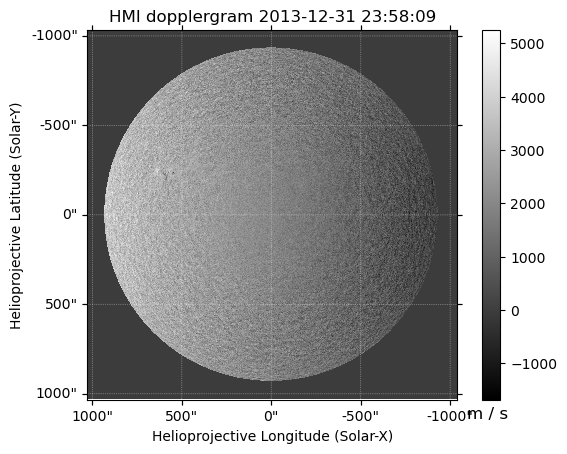

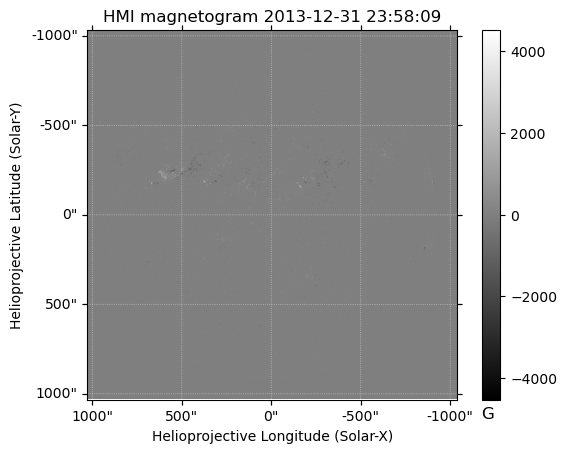

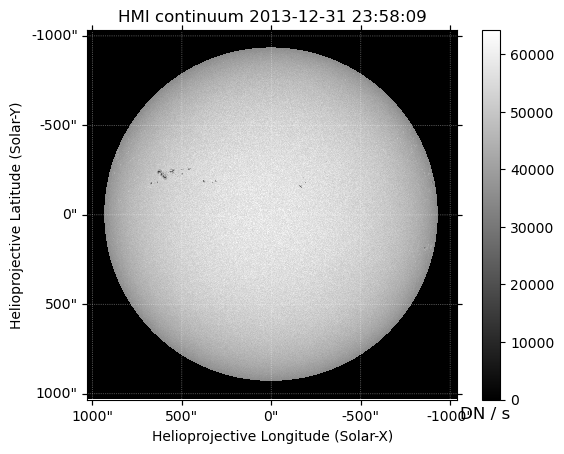

In [7]:
# remove unusable file types
good_files = []
for file in file_download:
    name, extension = os.path.splitext(file)
    if extension == '.fits':
        good_files.append(file)

# convert to map sequence
map_seq = sunpy.map.Map(sorted(good_files))

# check for missing data types
missing_map = False
# split into data types
for j, map_obj in enumerate(map_seq):
    if map_obj.meta['content'] == 'DOPPLERGRAM':
        vmap = map_obj
    elif map_obj.meta['content'] == 'MAGNETOGRAM':
        mmap = map_obj
    elif map_obj.meta['content'] == 'CONTINUUM INTENSITY':
        imap = map_obj

# coordinate transformation for maps
x, y, pdim, r, d, mu = ctfuncs.coordinates(vmap)
wij, nij, rij = ctfuncs.vel_coords(x, y, pdim, r, vmap)

# remove bad mu values
vmap, mmap, imap = ctfuncs.fix_mu(mu, [vmap, mmap, imap])

# quick peeks at the uncorrected images
vmap.peek()
mmap.peek()
imap.peek()



# Data Corrections

The downloaded images will require some correction before use.

### Velocity Corrections

To compute the actual surface velocity, we need to subtract from the Dopplergram the spacecraft velocity `vsc` and the solar rotational velocity `vrot`.

We save the new corrected Dopplergram as `map_vel_corr` and take a peek at it here.

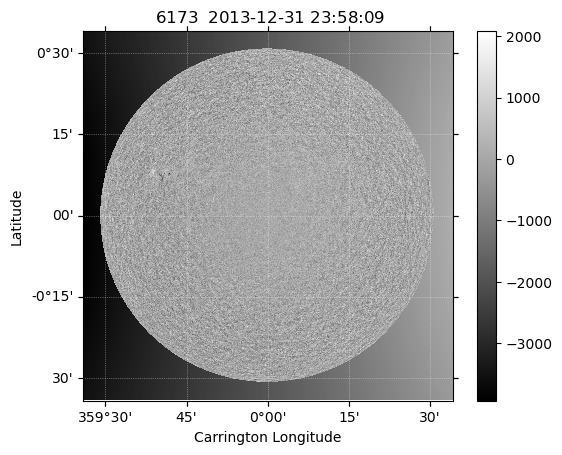

In [8]:
###### Velocity Corrections ######
# calculate relative positions
deltaw, deltan, deltar, dij = sfuncs.rel_positions(wij, nij, rij, vmap)

# calculate spacecraft velocity
vsc = sfuncs.spacecraft_vel(deltaw, deltan, deltar, dij, vmap)

# optimized solar rotation parameters
a_parameters = [Parameters.a1, Parameters.a2, Parameters.a3]

# calculation of solar rotation velocity
vrot = sfuncs.solar_rot_vel(wij, nij, rij, deltaw, deltan, deltar, dij, vmap, a_parameters)

# calculate corrected velocity
corrected_vel = vmap.data - np.real(vsc) - np.real(vrot)

# corrected velocity maps
map_vel_cor = sfuncs.corrected_map(corrected_vel, vmap, map_type='Corrected-Dopplergram',
                                               frame=frames.HeliographicCarrington)

map_vel_cor.peek()

### Limb Darkening

We flatten the intensitygram by dividing it by a limbdarkening polynomial.

The u and v coefficients are taken from **Allen 1973** based on the wavelength value. `SolAster` computed the polynomia in the `limb_polynomial` function. Its output is an array of the same size as the maps.

We save the flattened intensity map as `map_int_cor` and take a peek at it here.

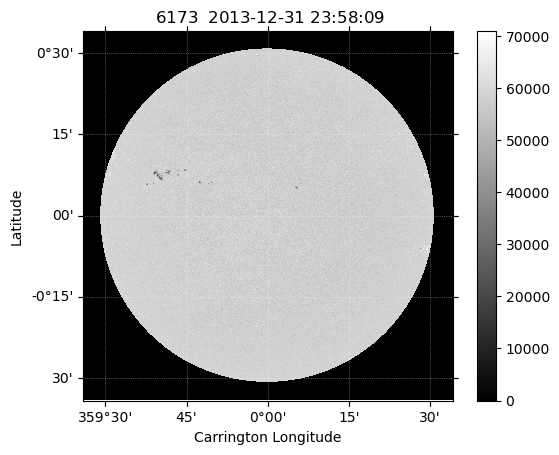

In [9]:
###### Limb Darkening Corrections ######
# limb brightening
Lij = lbfuncs.limb_polynomial(imap)

# calculate corrected data
Iflat = imap.data / Lij

# corrected intensity maps
map_int_cor = sfuncs.corrected_map(Iflat, imap, map_type='Corrected-Intensitygram',
                                               frame=frames.HeliographicCarrington)

map_int_cor.peek()


### Magnetic Foreshortening

We also include a correction for magnetic foreshortening. To do so we need to compute the unsigned magnetic field strength and magnetic noise. `SolAster` does so with the `mag_field` function.

Using the `Br` output we can generate a map of the true radial magnetic field, saved as `map_mag_cor`. We take a peek at it here.

We also include a bit of code to re-normalize and plot the magnetic field, for easier viewing.

`

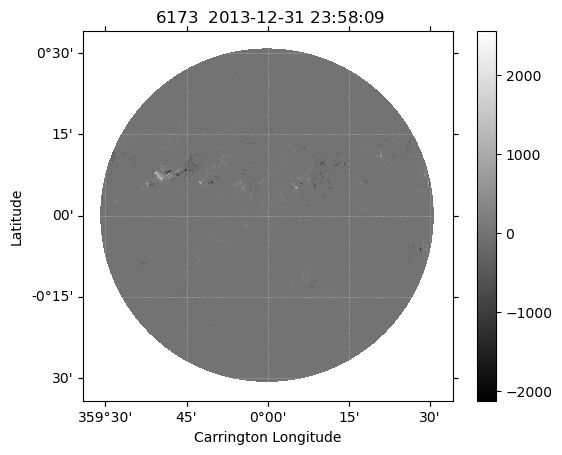

In [10]:
##### Magnetogram #####

# calculate unsigned field strength to correct for foreshortening 
Bobs, Br = sfuncs.mag_field(mu, mmap, B_noise=Parameters.B_noise, mu_cutoff=Parameters.mu_cutoff)

# corrected observed magnetic data map
map_mag_obs = sfuncs.corrected_map(Bobs, mmap, map_type='Corrected-Magnetogram',
                                               frame=frames.HeliographicCarrington)

# true radial magnetic data map
map_mag_cor = sfuncs.corrected_map(Br, mmap, map_type='Corrected-Magnetogram',
                                               frame=frames.HeliographicCarrington)

#map_mag_obs.peek()
map_mag_cor.peek()

# to see a bit better
normalize=False
if normalize:
    map_mag_cor.plot_settings['norm'] = plt.Normalize(-100, 100)
    map_mag_cor.plot()
    plt.show()

# Finding threshold values

We identify magnetic regions based on a magnetic cut-off value of 24 Gauss, taken from Yeo et. al. 2013. 

We can now divide the Sun into _active_ and _inactive_ regions.

Within these regions we can separate between bright active regions (which we can later further divide into network and plage/faculae) and dark active regions (spots). We map both into `fac_map` and `spot_map` and have a peek at them.

We finally generate a single map that identifies both, `map_full_thresh`. We include a commented-out line at the end to plot our new images.

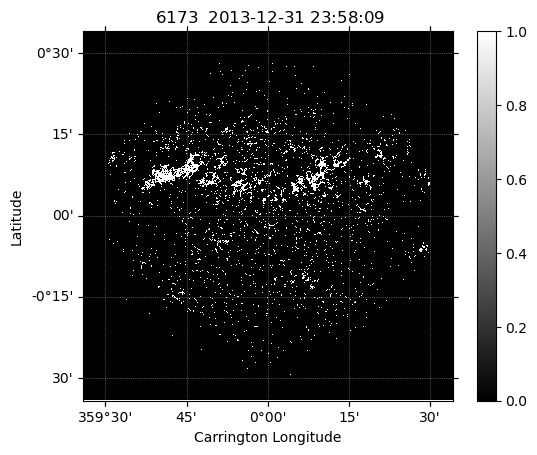

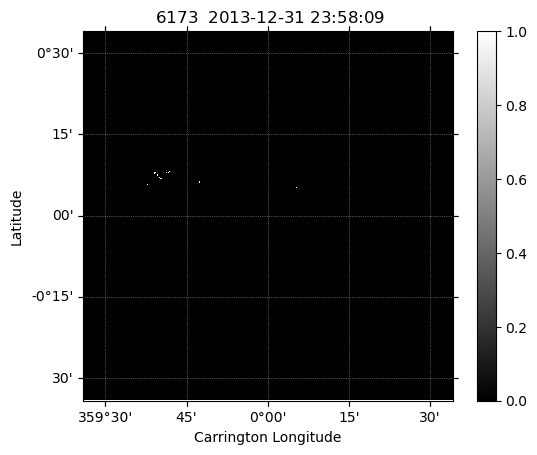

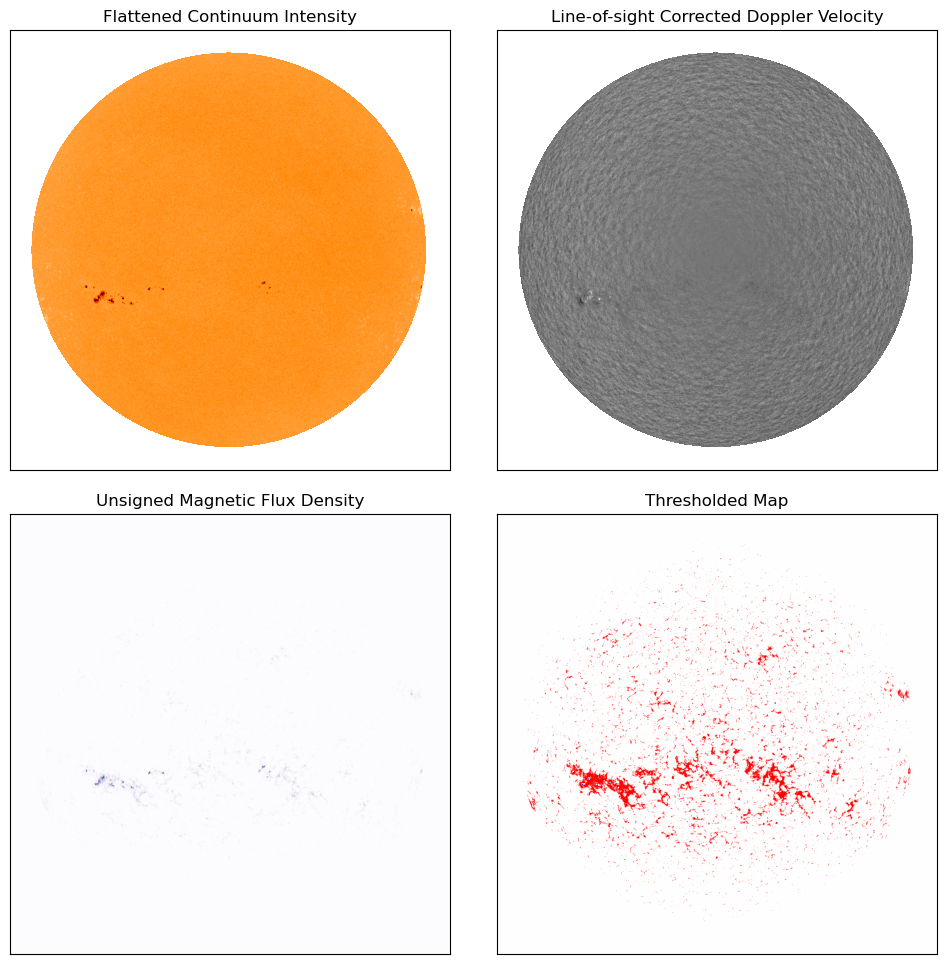

In [15]:
##### Find thresholds #####
# calculate magnetic threshold
#active, quiet = sfuncs.mag_thresh(mu, mmap, Br_cutoff=Parameters.Br_cutoff, mu_cutoff=Parameters.mu_cutoff)

active,quiet = sfuncs.mag_thresh(mu, mmap, Br_cutoff=Parameters.Br_cutoff, mu_cutoff=Parameters.mu_cutoff)

map_mag_thresh = sfuncs.corrected_map(active, mmap, map_type='Magnetic-Threshold',
                                                   frame=frames.HeliographicCarrington)
#map_mag_thresh.peek()



# calculate intensity threshold
fac_inds, spot_inds = sfuncs.int_thresh(map_int_cor, active, quiet)

# create faculae map objects
fac_map = sfuncs.corrected_map(fac_inds, mmap, map_type='Faculae', frame=frames.HeliographicCarrington)

# create sunspot map objects
spot_map = sfuncs.corrected_map(spot_inds, mmap, map_type='Sunspot', frame=frames.HeliographicCarrington)

fac_map.peek()
spot_map.peek()


# create threshold array
thresh_arr = sfuncs.thresh_map(fac_inds, spot_inds)

# full threshold maps
map_full_thresh = sfuncs.corrected_map(thresh_arr, mmap, map_type='Threshold',
                                                   frame=frames.HeliographicCarrington)



hmi_plot(map_int_cor, map_mag_obs, map_vel_cor, fac_inds, spot_inds, mu, save_fig=None)

# Filling Factors

From the identification of the active and inactive areas on the Sun we can now calculate the filling factors of bright regions and spots as a percentage of the total visible surface. To do so, `SolAster` uses the function `filling_factor`.

To include the size dependence of the active regions, `SolAster` uses the function `area_filling_factor`. We can now derive the filling factors of plage and network separately (their sum will be equal to the bright region filling factor called `f_fac`). We can also derve the fraction of small to large active regions. This separation is introduced in Milbourne et al. 2019 and will be relevant when computing the radial velocities.

In [16]:
##### Compute filling factors
f_bright, f_spot, f = sfuncs.filling_factor(mu, mmap, active, fac_inds, spot_inds, mu_cutoff=Parameters.mu_cutoff)

print(f'Bright regions: {f_bright:.2f}%')
print(f'Spots: {f_spot:.2f}%')

### calculate the area filling factor
pixA_hem = ctfuncs.pix_area_hem(wij, nij, rij, vmap)
area = sfuncs.area_calc(active, pixA_hem)
f_small, f_large, f_network, f_plage = sfuncs.area_filling_factor(active, area, mu, mmap,
                                                                             fac_inds, athresh=Parameters.athresh,
                                                                             mu_cutoff=Parameters.mu_cutoff)

print(f'Plage or faculae regions: {f_plage:.2f}%')
print(f'Bright Network: {f_network:.2f}%')

Bright regions: 4.15%
Spots: 0.02%
Plage or faculae regions: 1.98%
Bright Network: 2.17%


# Radial Velocity Derivation

We here follow the radial velocity derivation explained in Haywood et al. 2016 and Milbourne et al. 2019.

Radial velocities in SDO/HMI images are usually considered $\Delta$ RVs, since they depend on the Quiet-sun velocity (the average velocity of the non-magnetically active areas of the Sun).

The $\Delta$ RVs are computed from a model, a linear combination of two components: `v_phot` and `v_conv`.

`v_phot` is the velocity contribution due to the rotational Doppler imbalance generated by active regions. `v_conv` is the velocity contribution due to suppression of convective blueshift by active regions.

`rv_model` = `A`x`v_phot`+`B`x`v_conv`+`RV0`

The coefficients `A` and `B` depend on the telescope after which the SDO velocities are being normalized, and `RV0` is the required offset. We here explicitely list these values and in this tutorial we exclude the offset in the calculation to get the "raw" RV model. `SolAster` can directly compute the rv_model including offset with `calc_model`, depending on the selected instrument.

At the moment only HARPS-N and NEID normalisation is available.

In [17]:
##### Radial Velocity Computations in m/s #####

### velocity contribution due to convective motion of quiet-Sun
v_quiet = sfuncs.v_quiet(map_vel_cor, imap, quiet)

# calculate photospheric velocity
v_phot, vphot_bright, vphot_spot = sfuncs.v_phot(quiet, active, Lij, vrot, imap, mu, fac_inds, spot_inds, mu_cutoff=Parameters.mu_cutoff)

# calculate disc-averaged velocity
v_disc = sfuncs.v_disc(map_vel_cor, imap)
# calculate convective velocity
v_conv = v_disc - v_quiet

print(f'Photmetric velocity: {v_phot:.2f} m/s')
print(f'Convective velocity: {v_conv:.2f} m/s')

Photmetric velocity: -0.19 m/s
Convective velocity: 6.99 m/s


In [18]:
inst = "HARPS-N"
#inst = "NEID"

if inst.startswith("H"):
    # HARPS-N values
    A = 2.101
    B = 0.9825
    RV0 = 97.08
elif inst.startswith("N"):
    # NEID values
    A = 1.0983
    B = 1.423
    RV0 = -646.076
    print(2)
else:
    raise "Unknown instrument"

#rv_model = rvs.calc_model("HARPS-N", v_conv, v_phot)
rv_model = A * v_phot + B * v_conv

print(f'Derived radial velocity: {rv_model:.2f} m/s')

Derived radial velocity: 6.46 m/s


# Magnetic Fluxes

Studies such as Haywood et al. 2022 and Rescigno et al. (in prep) make use of the Sun-as-a-Star magnetic flux measurements derived from SDO/HMi images. We include how to compute them in the following section using the `SolAster` function `area_unsigned_flux`.

Here the unsigned (absolute) magnetic flux is saved as `unsigned_obs_flux`, while the polarised (longitudinal) magnetic flux is `pol_flux`. Both are in Gauss.

Other interesting values are: `quiet_flux` is the magnetic flux of the magnetically quiet regions, `ar_flux` the one of the magnetically active ones.

In [19]:
### Magnetic Flux

unsigned_obs_flux = sfuncs.unsigned_flux(map_mag_obs, imap)

quiet_flux, ar_flux, conv_flux, pol_flux, pol_conv_flux = sfuncs.area_unsigned_flux(map_mag_obs, imap,
                                                                                        area,
                                                                                        active,
                                                                                    athresh=Parameters.athresh)

### get area weighted convective velocities
vconv_quiet, vconv_large, vconv_small = sfuncs.area_vconv(map_vel_cor, imap, active, area, athresh=Parameters.athresh)

print(f'Unsigned Magnetic Flux: {unsigned_obs_flux:.2f} G')
print(f'Signed Magnetic Flux: {pol_flux:.2f} G')

Unsigned Magnetic Flux: 8.80 G
Signed Magnetic Flux: 0.32 G


# Saving the data

Now that we derived the main outputs of `SolAster`, we can save them. We again use `panda.DataFrame` to save to a csv file.


In [20]:
# make dictionary of what we want to save

save_vals = {
    "rv_model":rv_model,
     "v_quiet":v_quiet,
     "v_disc":v_disc,
     "v_phot":v_phot,
     "v_conv":v_conv,
     "f_bright":f_bright,
     "f_spot":f_spot,
     "f":f,
     "unsigned_obs_flux":unsigned_obs_flux,
     "vphot_bright":vphot_bright,
     "vphot_spot":vphot_spot,
     "f_small":f_small,
     "f_large":f_large,
     "f_network":f_network,
     "f_plage":f_plage,
     "quiet_flux":quiet_flux,
     "ar_flux":ar_flux,
     "conv_flux":conv_flux,
     "pol_flux":pol_flux,
     "unsigned_flux":unsigned_obs_flux,
     "pol_conv_flux":pol_conv_flux,
     "vconv_quiet":vconv_quiet,
     "vconv_large":vconv_large,
     "vconv_small":vconv_small
}


# save these values to the csv file
df = pd.concat((df,pd.DataFrame(save_vals, index=[0])))
df.to_csv(f'./{csv_name}.csv')
# print that the date is completed
print('\nCalculations and save to file complete')


Calculations and save to file complete


# Iterating with multiple images

Here we present the same process re-organized to be iterable, from data download to saving to file.

We also present another way of featching data with Fido.

This full tutorial and similar ones can be found at the [SolAster Website](https://tamarervin.github.io/SolAster/).

In [14]:
# date range
start_date = datetime.datetime(2023, 1, 10, 0, 00, 0)
end_date = datetime.datetime(2023, 1, 11, 0, 00, 0)

# query cadence in seconds (to download a single image per day, pick cadence = to a day)
cadence = 24*3600

# name of instrument to use for calculation of RV model
# choose either 'NEID' or 'HARPS-N'
inst = 'HARPS-N'

# get hmi data products
time_range = datetime.timedelta(seconds=22)
physobs_list = [a.Physobs.los_velocity, a.Physobs.los_magnetic_field, a.Physobs.intensity]

# get dates list
xy = (end_date - start_date).seconds + (end_date - start_date).days * 24 * 3600
dates_list = [start_date + datetime.timedelta(seconds=cadence*x) for x in range(0, int(xy/cadence))]


# name of csv file to store calculations
csv_name = 'timeseries_iterated'

# create file names
current_position = Path().resolve()
csv_file = os.path.join(current_position,csv_name+'.csv')
bad_dates_csv = os.path.join(current_position,csv_name+'_bad_dates.csv')

# List of header strings
row_contents = ['date_obs', 'date_jd', 'v_quiet', 'v_disc', 'v_phot', 'v_conv', 'f_bright', 'f_spot', 'f', 'Bobs',
                'vphot_bright', 'vphot_spot', 'f_small', 'f_large', 'f_network', 'f_plage', 'f_nonconv',
                'quiet_flux', 'ar_flux', 'conv_flux', 'unsigned_flux', 'pol_flux', 'pol_conv_flux', 'vconv_quiet', 'vconv_large',
                'vconv_small']

df = pd.DataFrame({i: [] for i in row_contents})
df.to_csv(f'./{csv_name}.csv')

Files Downloaded:   0%|          | 0/3 [00:00<?, ?file/s]


Calculations and save to file complete for 2023-01-10T00:00:00 index: 0
Calculation complete for dates: 2023-01-10 00:00:00 to 2023-01-11 00:00:00


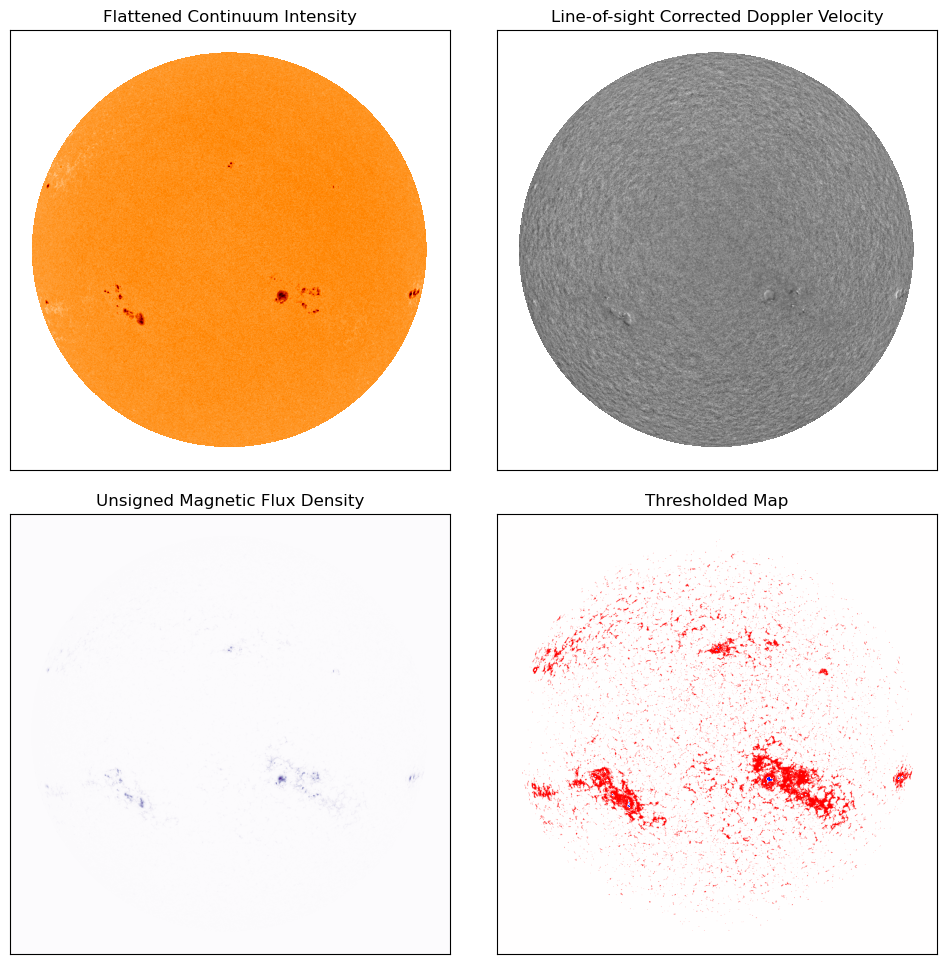

In [15]:
for i, date in enumerate(dates_list):
    # convert the date to a string -- required for use in csv file
    date_str, date_obj, date_jd = utils.get_dates(date)

    # pull image within specified time range
    result = Fido.search(a.Time(str(date_obj - time_range), str(date_obj + time_range)),
                        a.Instrument.hmi, physobs_list[0] | physobs_list[1] | physobs_list[2])

    # add file to list
    fido_download_path = os.path.join(current_position,"sunpy_download/{file}")
    file_download = Fido.fetch(result, path=fido_download_path)
    
    # remove unusable file types
    good_files = []
    for file in file_download:
        name, extension = os.path.splitext(file)
        if extension == '.fits':
            good_files.append(file)

    if len(good_files) != 3:
        # add the data
        # append these values to the csv file
        save_vals = [date_str, 'not three good files']
        # print that the files are missing
        print('\nNot three good files: ' + date_str + ' index: ' + str(i))

        pass
    else:
        # convert to map sequence
        map_seq = sunpy.map.Map(sorted(good_files))

        # check for missing data types
        missing_map = False
        # split into data types
        for j, map_obj in enumerate(map_seq):
            if map_obj.meta['content'] == 'DOPPLERGRAM':
                vmap = map_obj
            elif map_obj.meta['content'] == 'MAGNETOGRAM':
                mmap = map_obj
            elif map_obj.meta['content'] == 'CONTINUUM INTENSITY':
                imap = map_obj
            else:
                missing_map = True

        if missing_map:
            print("Missing a data product for " + date_str)

            # add the data
            # append these values to the csv file
            save_vals = [date_str, 'missing data product']
            pass

        else:
            # coordinate transformation for maps
            x, y, pdim, r, d, mu = ctfuncs.coordinates(vmap)
            wij, nij, rij = ctfuncs.vel_coords(x, y, pdim, r, vmap)

            # remove bad mu values
            vmap, mmap, imap = ctfuncs.fix_mu(mu, [vmap, mmap, imap])

            # calculate relative positions
            deltaw, deltan, deltar, dij = sfuncs.rel_positions(wij, nij, rij, vmap)

            # calculate spacecraft velocity
            vsc = sfuncs.spacecraft_vel(deltaw, deltan, deltar, dij, vmap)

            # optimized solar rotation parameters
            a_parameters = [Parameters.a1, Parameters.a2, Parameters.a3]

            # calculation of solar rotation velocity
            vrot = sfuncs.solar_rot_vel(wij, nij, rij, deltaw, deltan, deltar, dij, vmap, a_parameters)

            # calculate corrected velocity
            corrected_vel = vmap.data - np.real(vsc) - np.real(vrot)

            # corrected velocity maps
            map_vel_cor = sfuncs.corrected_map(corrected_vel, vmap, map_type='Corrected-Dopplergram',
                                               frame=frames.HeliographicCarrington)

            # limb brightening
            Lij = lbfuncs.limb_polynomial(imap)

            # calculate corrected data
            Iflat = imap.data / Lij

            # corrected intensity maps
            map_int_cor = sfuncs.corrected_map(Iflat, imap, map_type='Corrected-Intensitygram',
                                               frame=frames.HeliographicCarrington)

            # calculate unsigned field strength
            Bobs, Br = sfuncs.mag_field(mu, mmap, B_noise=Parameters.B_noise, mu_cutoff=Parameters.mu_cutoff)

            # corrected observed magnetic data map
            map_mag_obs = sfuncs.corrected_map(Bobs, mmap, map_type='Corrected-Magnetogram',
                                               frame=frames.HeliographicCarrington)

            # radial magnetic data map
            map_mag_cor = sfuncs.corrected_map(Br, mmap, map_type='Corrected-Magnetogram',
                                               frame=frames.HeliographicCarrington)

            # calculate magnetic threshold
            active, quiet = sfuncs.mag_thresh(mu, mmap, Br_cutoff=Parameters.Br_cutoff, mu_cutoff=Parameters.mu_cutoff)

            # calculate intensity threshold
            fac_inds, spot_inds = sfuncs.int_thresh(map_int_cor, active, quiet)

            # create threshold array
            thresh_arr = sfuncs.thresh_map(fac_inds, spot_inds)

            # full threshold maps
            map_full_thresh = sfuncs.corrected_map(thresh_arr, mmap, map_type='Threshold',
                                                   frame=frames.HeliographicCarrington)

            # create diagnostic plots
            if i == 0:
                hmi_plot(map_int_cor, map_mag_obs, map_vel_cor, fac_inds, spot_inds, mu, save_fig=None)

            ### velocity contribution due to convective motion of quiet-Sun
            v_quiet = sfuncs.v_quiet(map_vel_cor, imap, quiet)

            ### velocity contribution due to rotational Doppler imbalance of active regions (faculae/sunspots)
            # calculate photospheric velocity
            v_phot, vphot_bright, vphot_spot = sfuncs.v_phot(quiet, active, Lij, vrot, imap, mu, fac_inds, spot_inds, mu_cutoff=Parameters.mu_cutoff)

            ### velocity contribution due to suppression of convective blueshift by active regions
            # calculate disc-averaged velocity
            v_disc = sfuncs.v_disc(map_vel_cor, imap)

            # calculate convective velocity
            v_conv = v_disc - v_quiet

            ### filling factor
            # calculate filling factor
            f_bright, f_spot, f = sfuncs.filling_factor(mu, mmap, active, fac_inds, spot_inds, mu_cutoff=Parameters.mu_cutoff)

            ### unsigned magnetic flux
            # unsigned observed flux
            unsigned_obs_flux = sfuncs.unsigned_flux(map_mag_obs, imap)

            ### calculate the area filling factor
            pixA_hem = ctfuncs.pix_area_hem(wij, nij, rij, vmap)
            area = sfuncs.area_calc(active, pixA_hem)
            f_small, f_large, f_network, f_plage = sfuncs.area_filling_factor(active, area, mu, mmap,
                                                                                         fac_inds, athresh=Parameters.athresh,
                                                                                         mu_cutoff=Parameters.mu_cutoff)

            ### get the unsigned flux
            quiet_flux, ar_flux, conv_flux, pol_flux, pol_conv_flux = sfuncs.area_unsigned_flux(map_mag_obs, imap,
                                                                                                    area,
                                                                                                    active,
                                                                                                athresh=Parameters.athresh)

            ### get area weighted convective velocities
            vconv_quiet, vconv_large, vconv_small = sfuncs.area_vconv(map_vel_cor, imap, active, area, athresh=Parameters.athresh)

            ### calculate model RV
            rv_model = rvs.calc_model(inst, v_conv, v_phot)
            
            save_vals = {
                "rv_model":rv_model,
                 "v_quiet":v_quiet,
                 "v_disc":v_disc,
                 "v_phot":v_phot,
                 "v_conv":v_conv,
                 "f_bright":f_bright,
                 "f_spot":f_spot,
                 "f":f,
                 "unsigned_obs_flux":unsigned_obs_flux,
                 "vphot_bright":vphot_bright,
                 "vphot_spot":vphot_spot,
                 "f_small":f_small,
                 "f_large":f_large,
                 "f_network":f_network,
                 "f_plage":f_plage,
                 "quiet_flux":quiet_flux,
                 "ar_flux":ar_flux,
                 "conv_flux":conv_flux,
                 "pol_flux":pol_flux,
                 "unsigned_flux":unsigned_obs_flux,
                 "pol_conv_flux":pol_conv_flux,
                 "vconv_quiet":vconv_quiet,
                 "vconv_large":vconv_large,
                 "vconv_small":vconv_small
                }


            # save these values to the csv file
            ######### check for index!!!!
            df = pd.concat((df,pd.DataFrame(save_vals, index=[0])))
            df.to_csv(f'./{csv_name}.csv')

            # print that the date is completed
            print('\nCalculations and save to file complete for ' + date_str + ' index: ' + str(i))

print('Calculation complete for dates:', start_date, 'to', end_date)